In [ ]:
import os
import pandas as pd
import shutil

# Paths
image_directory = "/content/drive/MyDrive/DNN Project/DNN Project"
csv_file_path = "/content/class1 (2).csv"
output_directory = "/content/drive/MyDrive/Names Folde"

# Define valid image extensions
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"}

# Read CSV
df = pd.read_csv(csv_file_path)

# Ensure output directory exists
os.makedirs(output_directory, exist_ok=True)

# Process each row in the CSV
for _, row in df.iterrows():
    regno = str(row['Reg'])  # Convert regno to string to match folder names
    name = row['Name']

    # Create a new folder for the Name
    name_folder = os.path.join(output_directory, name)
    os.makedirs(name_folder, exist_ok=True)

    # Check if a folder named with regno exists in the image directory
    regno_folder = os.path.join(image_directory, regno)
    if os.path.isdir(regno_folder):
        # Traverse the regno folder and all its subdirectories
        for root, _, files in os.walk(regno_folder):
            for file in files:
                # Check if the file has a valid image extension
                if os.path.splitext(file)[1].lower() in valid_extensions:
                    src_path = os.path.join(root, file)
                    dest_path = os.path.join(name_folder, file)

                    # Copy the image to the new folder
                    shutil.copy(src_path, dest_path)

print("Process completed! Check the output directory.")


Process completed! Check the output directory.


In [2]:
!pip install mtcnn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00


In [ ]:
import shutil
import os

# Path to the main directory
main_directory = "/content/content"

# Path to the .ipynb_checkpoints folder
checkpoints_directory = os.path.join(main_directory, ".ipynb_checkpoints")

# Delete the .ipynb_checkpoints folder if it exists
if os.path.exists(checkpoints_directory):
    shutil.rmtree(checkpoints_directory)
    print(".ipynb_checkpoints directory has been removed.")
else:
    print(".ipynb_checkpoints directory does not exist.")


.ipynb_checkpoints directory does not exist.


In [8]:
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
import shutil

def get_class_names_from_directory(directory_path):
    """Retrieve class names from the directory."""
    class_names = [
        name
        for name in os.listdir(directory_path)
        if os.path.isdir(os.path.join(directory_path, name))
    ]
    class_names.sort()
    print(f"Class Names Found: {class_names}")
    return class_names


def clear_directory(directory):
    """Delete all files and subdirectories within a directory."""
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file or link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove directory
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")


def main_func_DNN_model_configuration():
    main_directory = "/content/drive/MyDrive/Names Folde"
    output_directory = "/content/MTCNN_Applied_dataset_file"

    # Initialize MTCNN
    detector = MTCNN()
    print("Cleaning the output directory...")
    clear_directory(output_directory)
    print("Output directory cleaned successfully!")
    # YOLO-specific paths
    images_train_dir = os.path.join(output_directory, "images/train")
    images_val_dir = os.path.join(output_directory, "images/val")
    labels_train_dir = os.path.join(output_directory, "labels/train")
    labels_val_dir = os.path.join(output_directory, "labels/val")

    # Create necessary directories
    for path in [images_train_dir, images_val_dir, labels_train_dir, labels_val_dir]:
        os.makedirs(path, exist_ok=True)

    # Get class names
    class_names = get_class_names_from_directory(main_directory)
    if not class_names:
        print("No class names found. Check the dataset directory.")
        return

    def process_image(image_path, img_output_dir, label_output_dir, student_label):
        """Process an image and save bounding boxes and YOLO annotations."""
        # print(f"Processing Image: {image_path}")
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to read image: {image_path}")
            return  # Skip this image

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(img_rgb)

        if not detections:
            print(f"No faces detected in: {image_path}")
            return

        class_id = class_names.index(student_label)  # Numeric class ID
        yolo_annotations = []
        for detection in detections:
            x, y, width, height = detection["box"]
            x_center = (x + width / 2) / img.shape[1]
            y_center = (y + height / 2) / img.shape[0]
            norm_width = width / img.shape[1]
            norm_height = height / img.shape[0]
            yolo_annotations.append(
                f"{class_id} {x_center} {y_center} {norm_width} {norm_height}"
            )

        # Save the processed image
        image_output_path = os.path.join(img_output_dir, os.path.basename(image_path))
        cv2.imwrite(image_output_path, img)
        print(f"Saved image to {image_output_path}")

        # Save YOLO annotations
        annotation_file = os.path.join(
            label_output_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}.txt"
        )
        with open(annotation_file, "w") as f:
            f.write("\n".join(yolo_annotations))
        # print(f"Saved annotations to {annotation_file}")

    # Split into train and validation sets
    train_ratio = 0.9
    all_images = []
    for student_dir in os.listdir(main_directory):
        student_path = os.path.join(main_directory, student_dir)
        if not os.path.isdir(student_path):
            continue
        for image_file in os.listdir(student_path):
            image_path = os.path.join(student_path, image_file)
            if os.path.isfile(image_path):
                all_images.append(image_path)

    if not all_images:
        print("No images found in the dataset.")
        return


    np.random.shuffle(all_images)
    train_count = int(len(all_images) * train_ratio)
    train_images = all_images[:train_count]
    val_images = all_images[train_count:]

    # Process training images
    # print("Processing training images...")
    for image_path in train_images:
        student_label = os.path.basename(os.path.dirname(image_path))
        process_image(image_path, images_train_dir, labels_train_dir, student_label)

    # Process validation images
    # print("Processing validation images...")
    for image_path in val_images:
        student_label = os.path.basename(os.path.dirname(image_path))
        process_image(image_path, images_val_dir, labels_val_dir, student_label)

    print("MTCNN Training Data Configuration Completed Successfully!")

main_func_DNN_model_configuration()


Cleaning the output directory...
Deleted: /content/MTCNN_Applied_dataset_file/labels
Deleted: /content/MTCNN_Applied_dataset_file/images
Output directory cleaned successfully!
Class Names Found: ['Aaiz Mohsin', 'Abdullah Noor', 'Abeera', 'Afaq Ahmad', 'Ahsan Saleem', 'Aiman Darakhshan', 'Ali Gohar', 'Ali Hassan', 'Ali Raza', 'Ali Vijdaan', 'Alishba Bacha', 'Anum Imran', 'Asad', 'Atta ur Rehman', 'Ayesha Khan', 'Behram Afgan Khan', 'Hamza Amin', 'Haris Bin Ismail', 'Haya Khan', 'Karrar Ahmed', 'Kashif Mehmood', 'Khizar Ahmad', 'M.Hashim Rabnawaz', 'M.Hassan Wadood', 'M.Mazz Hamid', 'M.Qasim Ali', 'Mahed Azhar Sheikh', 'Mahnoor Yasin', 'Malik Abdullah Awan', 'Mammon Rashid', 'Maqsood Ahmed', 'Maryam Ijaz', 'Maryam Taj', 'Mir Abdullah Talpur', 'Mubashi M.Khalid', 'Muhammad Mustafa', 'Naim Shahid', 'Noor Fatima', 'O said Khan', 'Reiaan Mazhar', 'Saifullah Saleem', 'Syed Hasaan Ahmed', 'Wardah Haya', 'Wasil Fawad Malik', 'Yasir Jamal']
Saved image to /content/MTCNN_Applied_dataset_file/imag

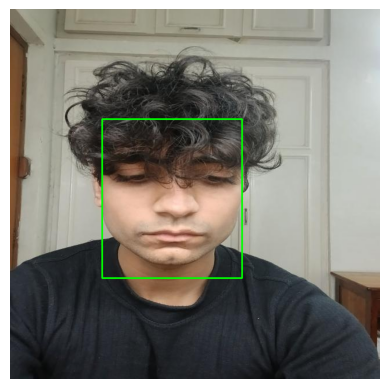

Saved image with bounding box to output_image_with_bounding_box.jpg


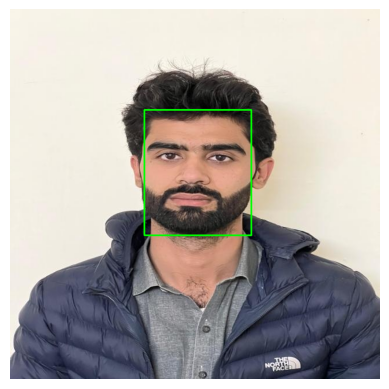

Saved image with bounding box to output_image_with_bounding_box.jpg


In [9]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_box(image_path, txt_file_path):
    """Draw bounding box on an image using the annotations in the txt file."""

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return

    # Convert image from BGR to RGB for displaying with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    height, width, _ = img.shape

    # Read the annotation file
    with open(txt_file_path, 'r') as f:
        annotations = f.readlines()

    # Process each annotation in the file
    for annotation in annotations:
        # Extract values from annotation line
        values = annotation.strip().split()
        class_id = int(values[0])  # Class ID (not used for drawing, but can be useful)
        x_center = float(values[1]) * width  # Convert normalized x center to pixels
        y_center = float(values[2]) * height  # Convert normalized y center to pixels
        norm_width = float(values[3]) * width  # Convert normalized width to pixels
        norm_height = float(values[4]) * height  # Convert normalized height to pixels

        # Calculate the top-left and bottom-right corners of the bounding box
        x1 = int(x_center - norm_width / 2)
        y1 = int(y_center - norm_height / 2)
        x2 = int(x_center + norm_width / 2)
        y2 = int(y_center + norm_height / 2)

        # Draw the bounding box on the image
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green color with thickness 2

    # Display the image with the bounding box using Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()

    # Optionally, save the image with bounding box drawn
    output_image_path = "output_image_with_bounding_box.jpg"
    cv2.imwrite(output_image_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    print(f"Saved image with bounding box to {output_image_path}")

# Example usage
image_path = "/content/MTCNN_Applied_dataset_file/images/train/2.jpg"
txt_file_path = "/content/MTCNN_Applied_dataset_file/labels/train/2.txt"
draw_bounding_box(image_path, txt_file_path)


# Example usage
image_path = "/content/MTCNN_Applied_dataset_file/images/train/1-1-_jpeg.rf.0535d58977bab5f642801ae9e18d9019.jpg"
txt_file_path = "/content/MTCNN_Applied_dataset_file/labels/train/1-1-_jpeg.rf.0535d58977bab5f642801ae9e18d9019.txt"
draw_bounding_box(image_path, txt_file_path)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
pip install mtcnn opencv-python-headless tensorflow numpy


In [11]:

!nvidia-smi

Sun Dec 22 15:50:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              26W /  70W |    119MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
names = ['Aaiz Mohsin', 'Abdullah Noor', 'Abeera', 'Afaq Ahmad', 'Ahsan Saleem', 'Aiman Darakhshan', 'Ali Gohar', 'Ali Hassan', 'Ali Raza', 'Ali Vijdaan', 'Alishba Bacha', 'Anum Imran', 'Asad', 'Atta ur Rehman', 'Ayesha Khan', 'Behram Afgan Khan', 'Hamza Amin', 'Haris Bin Ismail', 'Haya Khan', 'Karrar Ahmed', 'Kashif Mehmood', 'Khizar Ahmad', 'M.Hashim Rabnawaz', 'M.Hassan Wadood', 'M.Mazz Hamid', 'M.Qasim Ali', 'Mahed Azhar Sheikh', 'Mahnoor Yasin', 'Malik Abdullah Awan', 'Mammon Rashid', 'Maqsood Ahmed', 'Maryam Ijaz', 'Maryam Taj', 'Mir Abdullah Talpur', 'Mubashi M.Khalid', 'Muhammad Mustafa', 'Naim Shahid', 'Noor Fatima', 'O said Khan', 'Reiaan Mazhar', 'Saifullah Saleem', 'Syed Hasaan Ahmed', 'Wardah Haya', 'Wasil Fawad Malik', 'Yasir Jamal']

# Count the number of names
number_of_names = len(names)

print(number_of_names)


45


In [13]:
data_yaml_content = """
train: '/content/MTCNN_Applied_dataset_file/images/train'
val: '/content/MTCNN_Applied_dataset_file/images/val'

nc: 45
names: ['Aaiz Mohsin', 'Abdullah Noor', 'Abeera', 'Afaq Ahmad', 'Ahsan Saleem', 'Aiman Darakhshan', 'Ali Gohar', 'Ali Hassan', 'Ali Raza', 'Ali Vijdaan', 'Alishba Bacha', 'Anum Imran', 'Asad', 'Atta ur Rehman', 'Ayesha Khan', 'Behram Afgan Khan', 'Hamza Amin', 'Haris Bin Ismail', 'Haya Khan', 'Karrar Ahmed', 'Kashif Mehmood', 'Khizar Ahmad', 'M.Hashim Rabnawaz', 'M.Hassan Wadood', 'M.Mazz Hamid', 'M.Qasim Ali', 'Mahed Azhar Sheikh', 'Mahnoor Yasin', 'Malik Abdullah Awan', 'Mammon Rashid', 'Maqsood Ahmed', 'Maryam Ijaz', 'Maryam Taj', 'Mir Abdullah Talpur', 'Mubashi M.Khalid', 'Muhammad Mustafa', 'Naim Shahid', 'Noor Fatima', 'O said Khan', 'Reiaan Mazhar', 'Saifullah Saleem', 'Syed Hasaan Ahmed', 'Wardah Haya', 'Wasil Fawad Malik', 'Yasir Jamal']

# Augmentation settings
augmentation:
  mosaic: true       # Enable mosaic augmentation
  mixup: 0.4         # Increase mixup factor to 0.4 for more aggressive mixing
  flipud: 0.7        # Increase chance of vertical flip to 70%
  fliplr: 0.7        # Increase chance of horizontal flip to 70%
  hsv_h: 0.2         # Increase random shift in hue to 20%
  hsv_s: 0.8         # Increase random shift in saturation to 80%
  hsv_v: 0.6         # Increase random shift in brightness (value) to 60%
  rotate: 30         # Increase rotation to 45 degrees for more variability
  scale: 0.6         # Random scaling, 60% to 120%
  translate: 0.3     # Increase translation percentage to 30%
  perspective: 0.1   # Add random perspective distortion with 10% probability
  blur: 0.3          # Add random blur (Gaussian or motion) with 20% chance
  noise: 0.2         # Add random noise (e.g., Gaussian noise) with 10% probability

"""

# Write the modified content to the data.yaml file
with open("data.yaml", "w") as file:
    file.write(data_yaml_content)


In [14]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 25.1 MB/s eta 0:00:00


In [20]:
from ultralytics import YOLO, __version__

# Load a model
model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)

# Print the ultralytics library version
print(f"Ultralytics version: {__version__}")

# You can access model information using model.yaml
print(model.yaml)


Ultralytics version: 8.3.53
{'nc': 80, 'depth_multiple': 0.33, 'width_multiple': 0.5, 'backbone': [[-1, 1, 'Conv', [64, 3, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 3, 'C2f', [128, True]], [-1, 1, 'Conv', [256, 3, 2]], [-1, 6, 'C2f', [256, True]], [-1, 1, 'Conv', [512, 3, 2]], [-1, 6, 'C2f', [512, True]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 3, 'C2f', [1024, True]], [-1, 1, 'SPPF', [1024, 5]]], 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 6], 1, 'Concat', [1]], [-1, 3, 'C2f', [512]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 4], 1, 'Concat', [1]], [-1, 3, 'C2f', [256]], [-1, 1, 'Conv', [256, 3, 2]], [[-1, 12], 1, 'Concat', [1]], [-1, 3, 'C2f', [512]], [-1, 1, 'Conv', [512, 3, 2]], [[-1, 9], 1, 'Concat', [1]], [-1, 3, 'C2f', [1024]], [[15, 18, 21], 1, 'Detect', ['nc']]], 'ch': 3}


In [21]:
!yolo task=detect mode=train model='/content/yolov8s.pt' data='/content/data.yaml' epochs=300 imgsz=640 plots=True batch=8 amp=True patience=300 cos_lr=True pretrained=False augment=True


Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8s.pt, data=/content/data.yaml, epochs=300, time=None, patience=300, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

In [25]:
!yolo task=detect mode=predict model='/content/runs/detect/train2/weights/best.pt' source='/content/IMG_20241119_151836 (1).jpg' imgsz=640


Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,142,999 parameters, 0 gradients, 28.5 GFLOPs

image 1/1 /content/IMG_20241119_151836 (1).jpg: 640x576 1 Ali Vijdaan, 38.3ms
Speed: 3.6ms preprocess, 38.3ms inference, 581.7ms postprocess per image at shape (1, 3, 640, 576)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


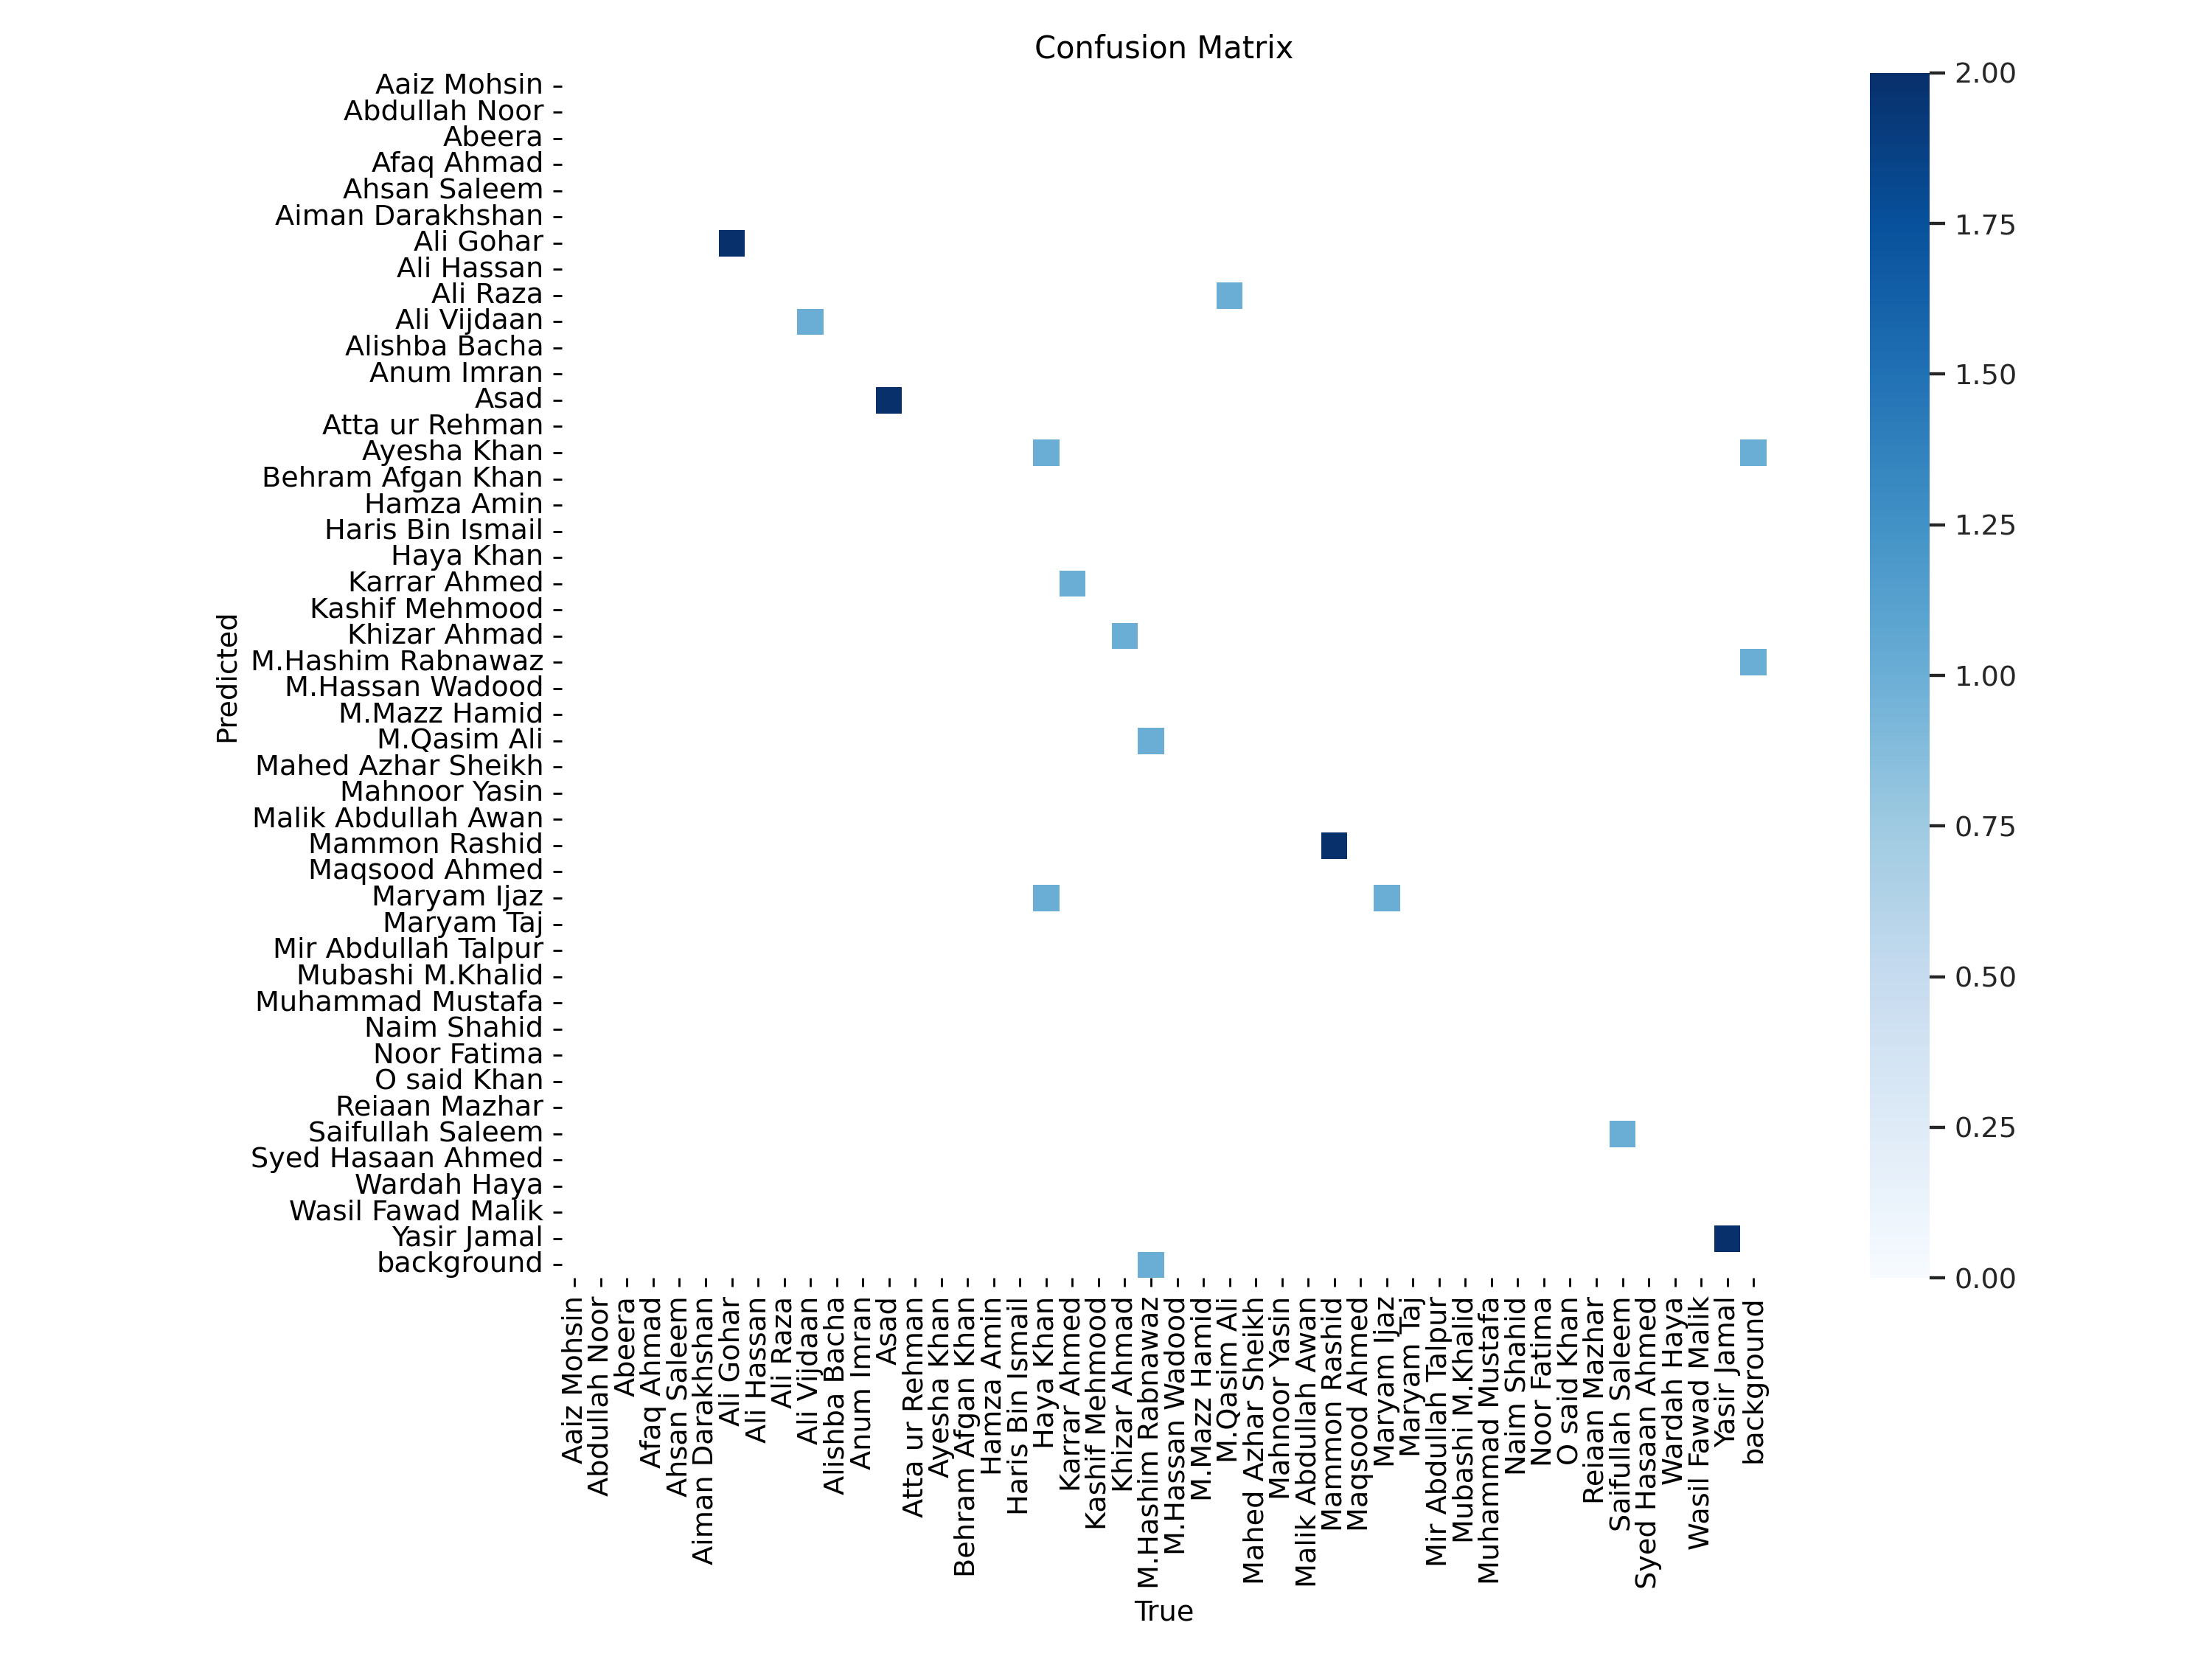

In [26]:

from IPython.display import display, Image
Image(filename='/content/runs/detect/train2/confusion_matrix.png', width=600)

In [ ]:
import pandas as pd
from ultralytics import YOLO

# Load the trained model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Define the persons you're interested in (you can adjust this list)
class_names = ['Abdullah Noor', 'Abeera', 'Afaq Ahmad', 'Ahsan Saleem', 'Ali Gohar', 'Ali Raza', 'Ali Vijdaan', 'Anum Imran', 'Asad', 'Ayesha Khan', 'Hamza Amin', 'Haya Khan', 'Karrar Ahmed', 'Kashif Mehmood', 'Khizar Ahmad', 'M.Hashim Rabnawaz', 'M.Mazz Hamid', 'M.Qasim Ali', 'Malik Abdullah Awan', 'Mammon Rashid', 'Maqsood Ahmed', 'Maryam Ijaz', 'Mubashi M.Khalid', 'Muhammad Mustafa', 'Naim Shahid', 'Noor Fatima', 'Saifullah Saleem', 'Yasir Jamal']

# Image path to predict on
image_path = '/content/WIN_20241106_21_34_56_Pro.jpg'

# Run prediction
results = model.predict(image_path, imgsz=650)

# Initialize a dictionary to store detection status for each person
detection_status = {name: 'A' for name in class_names}

# Iterate through the results (results is a list, so we access the first result)
for result in results:
    # Get the class names and boxes for the detected objects
    class_names_in_image = result.names  # Mapping class ids to class names
    boxes = result.boxes.xywh  # Bounding boxes (xywh format)

    # Iterate over the detections
    for i, box in enumerate(boxes):
        class_id = result.boxes.cls[i].item()  # Get the class ID
        class_name = class_names_in_image[class_id]  # Get the class name from the ID

        if class_name in detection_status:
            detection_status[class_name] = 'P'  # Mark as present (AP)

# Convert the dictionary to a DataFrame
df_result = pd.DataFrame([detection_status])

# Save the results to a CSV file
csv_file = '/content/detection_results.csv'
df_result.to_csv(csv_file, index=False)

# Display the results (for debugging)
print(df_result)



WARNING ⚠️ imgsz=[650] must be multiple of max stride 32, updating to [672]
image 1/1 /content/WIN_20241106_21_34_56_Pro.jpg: 672x640 1 Afaq Ahmad, 59.2ms
Speed: 3.2ms preprocess, 59.2ms inference, 1.8ms postprocess per image at shape (1, 3, 672, 640)
  Abdullah Noor Abeera Afaq Ahmad Ahsan Saleem Ali Gohar Ali Raza Ali Vijdaan  \
0             A      A          P            A         A        A           A   

  Anum Imran Asad Ayesha Khan  ... Malik Abdullah Awan Mammon Rashid  \
0          A    A           A  ...                   A             A   

  Maqsood Ahmed Maryam Ijaz Mubashi M.Khalid Muhammad Mustafa Naim Shahid  \
0             A           A                A                A           A   

  Noor Fatima Saifullah Saleem Yasir Jamal  
0           A                A           A  

[1 rows x 28 columns]
